# Model Runners
We have several different models with runners that we utilized for our manuscript that I will cover in this notebook:
- [BERT](#bert)
    - [Non-Parallelized BERT](#non-parallelized-bert)
    - [DistributedDataParallel (DDP) BERT](#distributeddataparallel-bert)  
- [Fully Connected Network (FCN)](#fully-connected-network)
- [GraphSAGE (GCN)](#graphsage) 
- [BLSTM](#blstm)
- [BERT-BLSTM](#bert-blstm)
    - [Initialized with RBD_Learned](#initialized-with-rbd_learned)
    - [Initialized with ESM](#initialized-with-esm)
- [ESM-BLSTM](#esm-blstm)

For running our models, we utilized 1-4 NVIDIA a100 80 GB GPUs. It is recommended to utilize GPU over CPU due to improved performance.

In [ ]:
import os
import sys
import tqdm
import torch
import textwrap
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn
from typing import Union
from prettytable import PrettyTable
from collections import defaultdict
from torch.utils.data import DataLoader, random_split

import copy
import torch
import torch.nn as nn
from pnlp.embedding.nlp_embedding import NLPEmbedding
from pnlp.model.transformer import TransformerBlock



Below is from a script `runner_util.py` that includes several "utility" functions that are called from the model runners.
- `save_model`
- `count_parameters`
- `calc_train_test_history`
- `plot_rmse_history`
- `plot_run`

In [9]:
def save_model(model, optimizer: torch.optim.SGD, epoch: int, save_as: str):
    """
    Save model parameters.

    model: a model object
    optimizer: model optimizer
    epoch: number of epochs in the end of the model running
    save_as: file name for saveing the model.
    """
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()},
                save_as)

def count_parameters(model):
    """
    Count model parameters and print a summary

    A nice hack from:
    https://stackoverflow.com/a/62508086/1992369
    """
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}\n")
    return total_params

def calc_train_test_history(metrics_csv: str, n_train: int, n_test: int, save_as: str):
    """ Calculate the average mse per item and rmse """

    history_df = pd.read_csv(metrics_csv, sep=',', header=0)

    history_df['train_loss_per'] = history_df['train_loss']/n_train  # average mse per item
    history_df['test_loss_per'] = history_df['test_loss']/n_test

    history_df['train_rmse'] = np.sqrt(history_df['train_loss_per'].values)  # rmse
    history_df['test_rmse'] = np.sqrt(history_df['test_loss_per'].values)

    history_df.to_csv(metrics_csv.replace('.csv', '_per.csv'), index=False)
    plot_rmse_history(history_df, save_as)

def plot_rmse_history(history_df, save_as: str):
    """ Plot RMSE training and testing history per epoch. """

    sns.set_theme()
    sns.set_context('talk')
    sns.set(style="darkgrid")

    # Converting mm to inches for figsize
    width_in = 88/25.4 # mm to inches
    ratio = 16/9
    height_in = width_in/ratio 
    fig, ax = plt.subplots(figsize=(width_in, height_in))
    plt.rcParams['font.family'] = 'sans-serif'

    # Plot
    sns.lineplot(data=history_df, x=history_df.index, y='test_rmse', color='tab:blue', linewidth=0.5, ax=ax) # add label='Test RMSE' for legend
    sns.lineplot(data=history_df, x=history_df.index, y='train_rmse', color='tab:orange', linewidth=0.5,ax=ax) # add label='Train RMSE' for legend
    
    # Set the font size
    font_size = 8
    ax.set_xlabel('Epoch', fontsize=font_size)
    ax.set_ylabel(f'RMSE', fontsize=font_size)
    ax.tick_params(axis='both', which='major', labelsize=font_size)
    # ax.legend(fontsize=font_size)

    # Skipping every other x-axis tick mark
    #ax.set_ylim(-0.1, 1.8)

    ax_xticks = ax.get_xticks()
    new_xlabels = ['' if i % 2 else label for i, label in enumerate(ax.get_xticklabels())]
    ax.set_xticks(ax_xticks)
    ax.set_xticklabels(new_xlabels)
    #ax.set_xlim(-100, 5000)

    plt.tight_layout()
    plt.savefig(save_as + '_rmse.pdf', format='pdf')

def plot_run(csv_name: str, save: bool = True):
    '''
    Generate a single figure with subplots for training loss and training accuracy
    from the model run csv file.

    For runner.py and gpu_ddp_runner.py
    '''
    df = pd.read_csv(csv_name)
    df.columns = df.columns.str.strip()

    sns.set_theme()
    sns.set_context('talk')
    sns.set(style="darkgrid")

    # Converting mm to inches for figsize
    width_in = 88/25.4 # mm to inches
    ratio = 16/9
    height_in = width_in/ratio 
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(width_in, 2*height_in))
    plt.rcParams['font.family'] = 'sans-serif'

    # Set the font size
    font_size = 8

    # Plot Training Loss
    train_loss_line = ax1.plot(df['epoch'], df['train_loss'], color='red', linewidth=0.5, label='Train Loss')
    test_loss_line = ax1.plot(df['epoch'], df['test_loss'], color='orange', linewidth=0.5, label='Test Loss')
    ax1.set_ylabel('Loss', fontsize=font_size)
    ax1.legend(loc='upper right', fontsize=font_size)
    ax1.tick_params(axis='both', which='major', labelsize=font_size)
    ax1.yaxis.get_offset_text().set_fontsize(font_size) 
    ax1.set_ylim(-0.5e6, 8e6) 

    # Plot Training Accuracy
    train_accuracy_line = ax2.plot(df['epoch'], df['train_accuracy']*100, color='blue', linewidth=0.5, label='Train Accuracy')
    test_accuracy_line = ax2.plot(df['epoch'], df['test_accuracy']*100, color='green', linewidth=0.5, label='Test Accuracy')
    ax2.set_xlabel('Epoch', fontsize=font_size)
    ax2.set_ylabel('Accuracy', fontsize=font_size)
    ax2.set_ylim(0, 100) 
    ax2.legend(loc='lower right', fontsize=font_size)
    ax2.tick_params(axis='both', which='major', labelsize=font_size)

    plt.tight_layout()

    if save:
        combined_fname = csv_name.replace('.csv', '_loss_acc.pdf')
        plt.savefig(combined_fname, format='pdf')


---
## BERT

In [18]:
""" BERT Model. """

class BERT(nn.Module):
    """ BERT model. """

    def __init__(self,
                 embedding_dim: int,
                 dropout: float,
                 max_len: int,
                 mask_prob: float,
                 # hidden: int,
                 n_transformer_layers: int,
                 attn_heads: int):
        """
        embedding_dim: dimensions of embedding
        hidden: BERT model size (used as input size and hidden size)
        n_layers: number of Transformer layers
        attn_heads: attenion heads
        dropout: dropout ratio
        """

        super().__init__()
        self.embedding_dim = embedding_dim
        self.dropout = dropout
        self.max_len = max_len
        self.mask_prob = mask_prob

        self.hidden  = embedding_dim
        self.n_transformer_layers = n_transformer_layers
        self.attn_heads = attn_heads
        self.feed_forward_hidden = self.hidden * 4         # 4 * hidden_size for FFN

        self.embedding = NLPEmbedding(self.embedding_dim, self.max_len, self.dropout)

        def clones(module, n):
            """Produce N identical layers"""
            return nn.ModuleList([copy.deepcopy(module) for _ in range(n)])

        self.transformer_blocks = clones(TransformerBlock(self.hidden, self.attn_heads, self.feed_forward_hidden, self.dropout), self.n_transformer_layers)

    def forward(self, x: torch.Tensor):
        embedded_seqs, mask_tensor = self.embedding(x)   # tokenized batch sequences

        for transformer in self.transformer_blocks:
            x = transformer.forward(embedded_seqs, mask_tensor)
        return x

### Non-Parallelized BERT

### DistributedDataParallel BERT

---
## Fully Connected Network
This section will cover the model runner found in `fcn_model_runner.py`. First, let's take a look at the fully connected network (FCN) model found in `fcn.py`, which we run using our model runner.

In [6]:
from torch import nn

class FCN(nn.Module):
    """ Fully Connected Network """

    def __init__(self,
                 fcn_input_size,     # The number of input features
                 fcn_hidden_size,    # The number of features in hidden layer of FCN.
                 device):            # Device ('cpu' or 'cuda')
        super().__init__()
        self.device = device

        # FCN layers
        self.fcn = nn.Sequential(nn.Linear(fcn_input_size, fcn_hidden_size),
                                 nn.ReLU(),
                                 nn.Linear(fcn_hidden_size, 1))  # Adjust this line based on the required output size

    def forward(self, x):
        fcn_out = self.fcn(x)
        fcn_final_out = fcn_out[:, -1, :]
        prediction = fcn_final_out.to(self.device)

        return prediction

In [10]:
import os
import sys
import tqdm
import torch
import pickle
import datetime
from typing import Union
from collections import defaultdict
from torch import nn
from torch.utils.data import Dataset, DataLoader
#from runner_util import save_model, count_parameters, calc_train_test_history

class EmbeddedDMSDataset(Dataset):
    """ Binding or Expression DMS Dataset """
    
    def __init__(self, pickle_file:str):
        """
        Load from pickle file:
        - sequence label (seq_id), 
        - binding or expression numerical target (log10Ka or ML_meanF), and 
        - embeddings
        """
        with open(pickle_file, 'rb') as f:
            dms_list = pickle.load(f)
        
            self.labels = [entry['seq_id'] for entry in dms_list]
            self.numerical = [entry["log10Ka" if "binding" in pickle_file else "ML_meanF"] for entry in dms_list]
            self.embeddings = [entry['embedding'] for entry in dms_list]

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx):
        # label, feature, target
        return self.labels[idx], self.embeddings[idx], self.numerical[idx]

def run_model(model, train_set, test_set, n_epochs: int, batch_size: int, lr:float, max_batch: Union[int, None], device: str, save_as: str):
    """ Run a model through train and test epochs. """
    
    if not max_batch:
        max_batch = len(train_set)

    model = model.to(device)
    loss_fn = nn.MSELoss(reduction='sum').to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr)

    train_loader = DataLoader(train_set, batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size, shuffle=True)
    
    metrics_csv = save_as + "_metrics.csv"

    with open(metrics_csv, "w") as fh:
        fh.write(f"epoch,"
                 f"train_loss,test_loss\n")

        for epoch in range(1, n_epochs + 1):
            train_loss = epoch_iteration(model, loss_fn, optimizer, train_loader, epoch, max_batch, device, mode='train')
            test_loss = epoch_iteration(model, loss_fn, optimizer, test_loader, epoch, max_batch, device, mode='test')

            print(f'Epoch {epoch} | Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}\n')
           
            fh.write(f"{epoch},"
                     f"{train_loss},{test_loss}\n")
            fh.flush()
                
            save_model(model, optimizer, epoch, save_as + '.model_save')

    return metrics_csv

def epoch_iteration(model, loss_fn, optimizer, data_loader, num_epochs: int, max_batch: int, device: str, mode: str):
    """ Used in run_model. """
    
    model.train() if mode=='train' else model.eval()

    data_iter = tqdm.tqdm(enumerate(data_loader),
                          desc=f'Epoch_{mode}: {num_epochs}',
                          total=len(data_loader),
                          bar_format='{l_bar}{r_bar}')

    total_loss = 0

    for batch, batch_data in data_iter:
        if max_batch > 0 and batch >= max_batch:
            break 
        
        label, feature, target = batch_data
        feature, target = feature.to(device), target.to(device) 
        target = target.float()

        if mode == 'train':
            optimizer.zero_grad()
            pred = model(feature).flatten()
            batch_loss = loss_fn(pred, target)
            batch_loss.backward()
            optimizer.step()

        else:
            with torch.no_grad():
                pred = model(feature).flatten()
                batch_loss = loss_fn(pred, target)
                
        total_loss += batch_loss.item()

    return total_loss

In [16]:
# Data/results directories
result_tag = 'fcn-esm_dms_binding' # specify rbd_learned or esm, and expression or binding
data_dir = '../data/pickles'
results_dir = '../results/run_results/fcn'

# Create run directory for results
now = datetime.datetime.now()
date_hour_minute = now.strftime("%Y-%m-%d_%H-%M")
run_dir = os.path.join(results_dir, f"{result_tag}-{date_hour_minute}")
os.makedirs(run_dir, exist_ok = True)

# Load in data
# embedded_train_pkl = os.path.join(data_dir, 'dms_mutation_expression_meanFs_train_esm_embedded.pkl') # fcn-esm_dms_expression
# embedded_test_pkl = os.path.join(data_dir, 'dms_mutation_expression_meanFs_test_esm_embedded.pkl')
embedded_train_pkl = os.path.join(data_dir, 'dms_mutation_binding_Kds_train_esm_embedded.pkl') # fcn-esm_dms_binding
embedded_test_pkl = os.path.join(data_dir, 'dms_mutation_binding_Kds_test_esm_embedded.pkl')
# embedded_train_pkl = os.path.join(data_dir, 'dms_mutation_expression_meanFs_train_rbd_learned_embedded_320.pkl') # fcn-rbd_learned_320_dms_expression
# embedded_test_pkl = os.path.join(data_dir, 'dms_mutation_expression_meanFs_test_rbd_learned_embedded_320.pkl')
# embedded_train_pkl = os.path.join(data_dir, 'dms_mutation_binding_Kds_train_rbd_learned_embedded_320.pkl') # fcn-rbd_learned_320_dms_binding
# embedded_test_pkl = os.path.join(data_dir, 'dms_mutation_binding_Kds_test_rbd_learned_embedded_320.pkl')
train_dataset = EmbeddedDMSDataset(embedded_train_pkl)
test_dataset = EmbeddedDMSDataset(embedded_test_pkl)

# Run setup
n_epochs = 10
batch_size = 32
max_batch = 10
lr = 1e-5
device = torch.device("cuda:0")

# FCN input
fcn_input_size = train_dataset.embeddings[0].size(1)   
fcn_hidden_size = fcn_input_size
model = FCN(fcn_input_size, fcn_hidden_size, device)

# Run
count_parameters(model)
model_result = os.path.join(run_dir, f"{result_tag}-{date_hour_minute}_train_{len(train_dataset)}_test_{len(test_dataset)}")
metrics_csv = run_model(model, train_dataset, test_dataset, n_epochs, batch_size, lr, max_batch, device, model_result)
calc_train_test_history(metrics_csv, len(train_dataset), len(test_dataset), model_result)


TypeError: EmbeddedDMSDataset.__init__() missing 1 required positional argument: 'device'

--- 
## GraphSAGE

In [12]:
""" GraphSAGE model. """

from torch import nn
from torch_geometric.nn import SAGEConv, global_mean_pool

class GraphSAGE(nn.Module):
    """ GraphSAGE. """

    def __init__(self, in_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, 16)
        self.conv2 = SAGEConv(16, out_channels)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)
        return x

In [14]:
import os
import sys
import tqdm
import torch
import pickle
import datetime
from typing import Union
from collections import defaultdict
from torch import nn
from torch_geometric.nn import SAGEConv, global_mean_pool
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.utils.data import Dataset
#from runner_util import save_model, count_parameters, calc_train_test_history

class EmbeddedDMSDataset(Dataset):
    """ Binding or Expression DMS Dataset """
    
    def __init__(self, pickle_file:str, device:str):
        """
        Load from pickle file:
        - sequence label (seq_id), 
        - binding or expression numerical target (log10Ka or ML_meanF), and 
        - embeddings
        """
        with open(pickle_file, 'rb') as f:
            dms_list = pickle.load(f)
        
            self.labels = [entry['seq_id'] for entry in dms_list]
            self.numerical = [entry["log10Ka" if "binding" in pickle_file else "ML_meanF"] for entry in dms_list]
            self.embeddings = [entry['embedding'] for entry in dms_list]
 
    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx):
        # Convert to pytorch geometric graph
        embedding = self.embeddings[idx].to(device) 
        edges = [(i, i+1) for i in range(embedding.size(0) - 1)]
        edge_index = torch.tensor(edges, dtype=torch.int64).t().contiguous()
        y = torch.tensor([self.numerical[idx]], dtype=torch.float32).view(-1, 1)
        
        return Data(x=embedding, edge_index=edge_index, y=y)

def run_model(model, train_set, test_set, n_epochs: int, batch_size: int, lr:float, max_batch: Union[int, None], device: str, save_as: str):
    """ Run a model through train and test epochs. """
    
    if not max_batch:
        max_batch = len(train_set)

    model = model.to(device)
    loss_fn = nn.MSELoss(reduction='sum').to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr)

    train_loader = DataLoader(train_set, batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size, shuffle=True)
    
    metrics_csv = save_as + "_metrics.csv"

    with open(metrics_csv, "w") as fh:
        fh.write(f"epoch,"
                 f"train_loss,test_loss\n")

        for epoch in range(1, n_epochs + 1):
            train_loss = epoch_iteration(model, loss_fn, optimizer, train_loader, epoch, max_batch, device, mode='train')
            test_loss = epoch_iteration(model, loss_fn, optimizer, test_loader, epoch, max_batch, device, mode='test')

            print(f'Epoch {epoch} | Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}\n')
           
            fh.write(f"{epoch},"
                     f"{train_loss},{test_loss}\n")
            fh.flush()
                
            save_model(model, optimizer, epoch, save_as + '.model_save')

    return metrics_csv

def epoch_iteration(model, loss_fn, optimizer, data_loader, num_epochs: int, max_batch: int, device: str, mode: str):
    """ Used in run_model. """

    model.train() if mode=='train' else model.eval()

    data_iter = tqdm.tqdm(enumerate(data_loader),
                          desc=f'Epoch_{mode}: {num_epochs}',
                          total=len(data_loader),
                          bar_format='{l_bar}{r_bar}')

    total_loss = 0

    for batch, batch_data in data_iter:
        if max_batch > 0 and batch >= max_batch:
            break

        batch_data = batch_data.to(device)

        if mode == 'train':
            optimizer.zero_grad()
            pred = model(batch_data.x, batch_data.edge_index, batch_data.batch)
            batch_loss = loss_fn(pred, batch_data.y)
            batch_loss.backward()
            optimizer.step()

        else:
            with torch.no_grad():
                pred = model(batch_data.x, batch_data.edge_index, batch_data.batch)
                batch_loss = loss_fn(pred, batch_data.y)

        total_loss += batch_loss.item()

    return total_loss

+--------------------+------------+
|      Modules       | Parameters |
+--------------------+------------+
| conv1.lin_l.weight |    5120    |
|  conv1.lin_l.bias  |     16     |
| conv1.lin_r.weight |    5120    |
| conv2.lin_l.weight |     16     |
|  conv2.lin_l.bias  |     1      |
| conv2.lin_r.weight |     16     |
+--------------------+------------+
Total Trainable Params: 10289



Epoch_test: 1:   2%|| 10/660 [00:00<00:04, 155.81it/s]


Epoch 1 | Train Loss: 20681.9192, Test Loss: 18543.7797



Epoch_test: 2:   2%|| 10/660 [00:00<00:04, 156.67it/s]


Epoch 2 | Train Loss: 16591.7802, Test Loss: 13549.2529



Epoch_test: 3:   2%|| 10/660 [00:00<00:04, 156.53it/s]


Epoch 3 | Train Loss: 9697.9343, Test Loss: 6644.0107



Epoch_test: 4:   2%|| 10/660 [00:00<00:04, 157.18it/s]


Epoch 4 | Train Loss: 4004.3677, Test Loss: 2296.3543



Epoch_test: 5:   2%|| 10/660 [00:00<00:04, 156.33it/s]


Epoch 5 | Train Loss: 1697.1881, Test Loss: 1258.4189



Epoch_test: 6:   2%|| 10/660 [00:00<00:04, 156.60it/s]


Epoch 6 | Train Loss: 1290.3947, Test Loss: 1206.8367



Epoch_test: 7:   2%|| 10/660 [00:00<00:04, 154.69it/s]


Epoch 7 | Train Loss: 1125.0086, Test Loss: 1217.6553



Epoch_test: 8:   2%|| 10/660 [00:00<00:04, 156.16it/s]


Epoch 8 | Train Loss: 1144.1322, Test Loss: 1108.9380



Epoch_test: 9:   2%|| 10/660 [00:00<00:04, 155.75it/s]


Epoch 9 | Train Loss: 1112.6130, Test Loss: 1077.0939



Epoch_test: 10:   2%|| 10/660 [00:00<00:04, 156.10it/s]


Epoch 10 | Train Loss: 1209.6979, Test Loss: 1165.5435



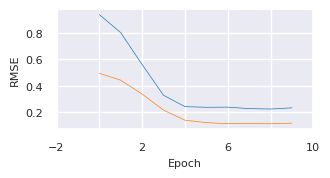

In [17]:
# Data/results directories
result_tag = 'graphsage-esm_dms_binding' # specify rbd_learned or esm, and expression or binding
data_dir = '../data/pickles'
results_dir = '../results/run_results/graphsage'

# Create run directory for results
now = datetime.datetime.now()
date_hour_minute = now.strftime("%Y-%m-%d_%H-%M")
run_dir = os.path.join(results_dir, f"{result_tag}-{date_hour_minute}")
os.makedirs(run_dir, exist_ok = True)

# Load in data
# embedded_train_pkl = os.path.join(data_dir, 'dms_mutation_expression_meanFs_train_esm_embedded.pkl') # graphsage-esm_dms_expression
# embedded_test_pkl = os.path.join(data_dir, 'dms_mutation_expression_meanFs_test_esm_embedded.pkl')
embedded_train_pkl = os.path.join(data_dir, 'dms_mutation_binding_Kds_train_esm_embedded.pkl') # graphsage-esm_dms_binding
embedded_test_pkl = os.path.join(data_dir, 'dms_mutation_binding_Kds_test_esm_embedded.pkl')
# embedded_train_pkl = os.path.join(data_dir, 'dms_mutation_expression_meanFs_train_rbd_learned_embedded_320.pkl') # graphsage-rbd_learned_320_dms_expression
# embedded_test_pkl = os.path.join(data_dir, 'dms_mutation_expression_meanFs_test_rbd_learned_embedded_320.pkl')
# embedded_train_pkl = os.path.join(data_dir, 'dms_mutation_binding_Kds_train_rbd_learned_embedded_320.pkl') # graphsage-rbd_learned_320_dms_binding
# embedded_test_pkl = os.path.join(data_dir, 'dms_mutation_binding_Kds_test_rbd_learned_embedded_320.pkl')

device = torch.device("cuda:3")
train_dataset = EmbeddedDMSDataset(embedded_train_pkl, device)
test_dataset = EmbeddedDMSDataset(embedded_test_pkl, device)

# Run setup
n_epochs = 10
batch_size = 32
max_batch = 10
lr = 1e-5

# GraphSAGE input
input_channels = train_dataset.embeddings[0].size(1) # number of input channels (dimensions of the embeddings)
out_channels = 1  # For regression output
model = GraphSAGE(input_channels, out_channels).to(device)

# Run
count_parameters(model)
model_result = os.path.join(run_dir, f"{result_tag}-{date_hour_minute}_train_{len(train_dataset)}_test_{len(test_dataset)}")
metrics_csv = run_model(model, train_dataset, test_dataset, n_epochs, batch_size, lr, max_batch, device, model_result)
calc_train_test_history(metrics_csv, len(train_dataset), len(test_dataset), model_result)

---
## BLSTM

In [22]:
""" BLSTM model with FCN layer. """

import torch
from torch import nn

class BLSTM(nn.Module):
    """ Bidirectional LSTM with FCN layer. """

    def __init__(self,
                 lstm_input_size,    # The number of expected features.
                 lstm_hidden_size,   # The number of features in hidden state h.
                 lstm_num_layers,    # Number of recurrent layers in LSTM.
                 lstm_bidirectional, # Bidrectional LSTM.
                 fcn_hidden_size):   # The number of features in hidden layer of CN.
        super().__init__()

        # LSTM layer
        self.lstm = nn.LSTM(input_size=lstm_input_size,
                            hidden_size=lstm_hidden_size,
                            num_layers=lstm_num_layers,
                            bidirectional=lstm_bidirectional,
                            batch_first=True)           

        # FCN
        if lstm_bidirectional:
            self.fcn = nn.Sequential(nn.Linear(2 * lstm_hidden_size, fcn_hidden_size),
                                     nn.ReLU())
        else:
            self.fcn = nn.Sequential(nn.Linear(lstm_hidden_size, fcn_hidden_size),
                                     nn.ReLU())

        # FCN output layer
        self.out = nn.Linear(fcn_hidden_size, 1)

    def forward(self, x):
        num_directions = 2 if self.lstm.bidirectional else 1
        h_0 = torch.zeros(num_directions * self.lstm.num_layers, x.size(0), self.lstm.hidden_size, device=x.device)
        c_0 = torch.zeros(num_directions * self.lstm.num_layers, x.size(0), self.lstm.hidden_size, device=x.device)

        lstm_out, (h_n, c_n) = self.lstm(x, (h_0, c_0))
        h_n.detach()
        c_n.detach()
        lstm_final_out = lstm_out[:, -1, :]
        fcn_out = self.fcn(lstm_final_out)
        prediction = self.out(fcn_out)

        return prediction


In [20]:
import os
import sys
import tqdm
import torch
import pickle
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Union
from collections import defaultdict
from torch import nn
from torch.utils.data import Dataset, DataLoader
#from runner_util import save_model, count_parameters, calc_train_test_history
from transformers import AutoTokenizer, EsmModel 
from pnlp.embedding.tokenizer import ProteinTokenizer, token_to_index
from pnlp.model.language import BERT


class EmbeddedDMSDataset(Dataset):
    """ Binding or Expression DMS Dataset """
    
    def __init__(self, pickle_file:str, device:str):
        """
        Load from pickle file:
        - sequence label (seq_id), 
        - binding or expression numerical target (log10Ka or ML_meanF), and 
        - embeddings
        """
        with open(pickle_file, 'rb') as f:
            dms_list = pickle.load(f)
        
            self.labels = [entry['seq_id'] for entry in dms_list]
            self.numerical = [entry["log10Ka" if "binding" in pickle_file else "ML_meanF"] for entry in dms_list]
            self.embeddings = [entry['embedding'] for entry in dms_list]

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx):
        # label, feature, target
        return self.labels[idx], self.embeddings[idx].to(device), self.numerical[idx]

def run_model(model, train_set, test_set, n_epochs: int, batch_size: int, lr:float, max_batch: Union[int, None], device: str, save_as: str):
    """ Run a model through train and test epochs. """
    
    if not max_batch:
        max_batch = len(train_set)

    model = model.to(device)
    loss_fn = nn.MSELoss(reduction='sum').to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr)

    train_loader = DataLoader(train_set, batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size, shuffle=True)
    
    metrics_csv = save_as + "_metrics.csv"

    with open(metrics_csv, "w") as fh:
        fh.write(f"epoch,"
                 f"train_loss,test_loss\n")

        for epoch in range(1, n_epochs + 1):
            train_loss = epoch_iteration(model, loss_fn, optimizer, train_loader, epoch, max_batch, device, mode='train')
            test_loss = epoch_iteration(model, loss_fn, optimizer, test_loader, epoch, max_batch, device, mode='test')

            print(f'Epoch {epoch} | Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}\n')
           
            fh.write(f"{epoch},"
                     f"{train_loss},{test_loss}\n")
            fh.flush()
                
            save_model(model, optimizer, epoch, save_as + '.model_save')

    return metrics_csv

def epoch_iteration(model, loss_fn, optimizer, data_loader, num_epochs: int, max_batch: int, device: str, mode: str):
    """ Used in run_model. """
    
    model.train() if mode=='train' else model.eval()

    data_iter = tqdm.tqdm(enumerate(data_loader),
                          desc=f'Epoch_{mode}: {num_epochs}',
                          total=len(data_loader),
                          bar_format='{l_bar}{r_bar}')

    total_loss = 0

    for batch, batch_data in data_iter:
        if max_batch > 0 and batch >= max_batch:
            break 
        
        label, feature, target = batch_data
        feature, target = feature.to(device), target.to(device) 
        target = target.float()

        if mode == 'train':
            optimizer.zero_grad()
            pred = model(feature).flatten()
            batch_loss = loss_fn(pred, target)
            batch_loss.backward()
            optimizer.step()

        else:
            with torch.no_grad():
                pred = model(feature).flatten()
                batch_loss = loss_fn(pred, target)
                
        total_loss += batch_loss.item()

    return total_loss

+---------------------------+------------+
|          Modules          | Parameters |
+---------------------------+------------+
|     lstm.weight_ih_l0     |   409600   |
|     lstm.weight_hh_l0     |   409600   |
|      lstm.bias_ih_l0      |    1280    |
|      lstm.bias_hh_l0      |    1280    |
| lstm.weight_ih_l0_reverse |   409600   |
| lstm.weight_hh_l0_reverse |   409600   |
|  lstm.bias_ih_l0_reverse  |    1280    |
|  lstm.bias_hh_l0_reverse  |    1280    |
|        fcn.0.weight       |   204800   |
|         fcn.0.bias        |    320     |
|         out.weight        |    320     |
|          out.bias         |     1      |
+---------------------------+------------+
Total Trainable Params: 1848961



Epoch_test: 1:   2%|| 10/660 [00:00<00:02, 278.60it/s]


Epoch 1 | Train Loss: 20861.7759, Test Loss: 19848.5503



Epoch_test: 2:   2%|| 10/660 [00:00<00:02, 311.03it/s]


Epoch 2 | Train Loss: 20371.5575, Test Loss: 19515.6237



Epoch_test: 3:   2%|| 10/660 [00:00<00:02, 310.82it/s]


Epoch 3 | Train Loss: 20165.5474, Test Loss: 19689.0728



Epoch_test: 4:   2%|| 10/660 [00:00<00:02, 306.79it/s]


Epoch 4 | Train Loss: 18256.6000, Test Loss: 18978.3434



Epoch_test: 5:   2%|| 10/660 [00:00<00:02, 312.38it/s]


Epoch 5 | Train Loss: 16895.8206, Test Loss: 17339.1030



Epoch_test: 6:   2%|| 10/660 [00:00<00:02, 310.83it/s]


Epoch 6 | Train Loss: 16995.4865, Test Loss: 16734.6075



Epoch_test: 7:   2%|| 10/660 [00:00<00:02, 311.99it/s]


Epoch 7 | Train Loss: 15938.2415, Test Loss: 15637.3993



Epoch_test: 8:   2%|| 10/660 [00:00<00:02, 312.30it/s]


Epoch 8 | Train Loss: 14831.6156, Test Loss: 14599.1818



Epoch_test: 9:   2%|| 10/660 [00:00<00:02, 312.07it/s]


Epoch 9 | Train Loss: 14011.8594, Test Loss: 12105.1151



Epoch_test: 10:   2%|| 10/660 [00:00<00:02, 310.05it/s]


Epoch 10 | Train Loss: 11662.7029, Test Loss: 10288.1180



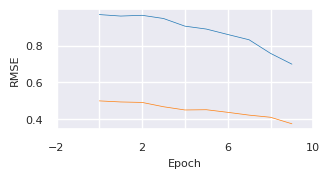

In [23]:
# Data/results directories
result_tag = 'blstm-esm_dms_binding' # specify expression or binding, esm or rbd_learned
data_dir = '../data/pickles'
results_dir = '../results/run_results/blstm'

# Create run directory for results
now = datetime.datetime.now()
date_hour_minute = now.strftime("%Y-%m-%d_%H-%M")
run_dir = os.path.join(results_dir, f"{result_tag}-{date_hour_minute}")
os.makedirs(run_dir, exist_ok = True)

# Load in data (from pickle)
# embedded_train_pkl = os.path.join(data_dir, 'dms_mutation_expression_meanFs_train_esm_embedded.pkl') # blstm-esm_dms_expression
# embedded_test_pkl = os.path.join(data_dir, 'dms_mutation_expression_meanFs_test_esm_embedded.pkl')
embedded_train_pkl = os.path.join(data_dir, 'dms_mutation_binding_Kds_train_esm_embedded.pkl') # blstm-esm_dms_binding
embedded_test_pkl = os.path.join(data_dir, 'dms_mutation_binding_Kds_test_esm_embedded.pkl')

# embedded_train_pkl = os.path.join(data_dir, 'dms_mutation_expression_meanFs_train_rbd_learned_embedded_320.pkl') # blstm-rbd_learned_320_dms_expression
# embedded_test_pkl = os.path.join(data_dir, 'dms_mutation_expression_meanFs_test_rbd_learned_embedded_320.pkl')
# embedded_train_pkl = os.path.join(data_dir, 'dms_mutation_binding_Kds_train_rbd_learned_embedded_320.pkl') # blstm-rbd_learned_320_dms_binding
# embedded_test_pkl = os.path.join(data_dir, 'dms_mutation_binding_Kds_test_rbd_learned_embedded_320.pkl')

device = torch.device("cuda:0")
train_dataset = EmbeddedDMSDataset(embedded_train_pkl, device)
test_dataset = EmbeddedDMSDataset(embedded_test_pkl, device)

# Run setup
n_epochs = 10
batch_size = 32
max_batch = 10
lr = 1e-5

# BLSTM input
lstm_input_size = 320
lstm_hidden_size = 320
lstm_num_layers = 1        
lstm_bidrectional = True   
fcn_hidden_size = 320
model = BLSTM(lstm_input_size, lstm_hidden_size, lstm_num_layers, lstm_bidrectional, fcn_hidden_size)

# Run
count_parameters(model)
model_result = os.path.join(run_dir, f"{result_tag}-{date_hour_minute}_train_{len(train_dataset)}_test_{len(test_dataset)}")
metrics_csv = run_model(model, train_dataset, test_dataset, n_epochs, batch_size, lr, max_batch, device, model_result)
calc_train_test_history(metrics_csv, len(train_dataset), len(test_dataset), model_result)

---
## BERT-BLSTM

In [ ]:
""" BLSTM with FCN layer, MLM, and BERT. """

import torch
import torch.nn as nn
from pnlp.model.language import ProteinMaskedLanguageModel, BERT
from model.blstm import BLSTM

class BERT_BLSTM(nn.Module):
    """" BLSTM with FCN layer, MLM, and BERT. """
    
    def __init__(self, bert: BERT, blstm:BLSTM, vocab_size: int):
        super().__init__()

        self.bert = bert
        self.mlm = ProteinMaskedLanguageModel(self.bert.hidden, vocab_size)
        self.blstm = blstm

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.bert(x)
        error_1 = self.mlm(x) # error from masked language
        error_2 = self.blstm(x) # error from regession

        return error_1, error_2

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_combined_history(history_df: str, save_as):
    """
    Generate a single figure with subplots for combined training loss
    from the model run csv file.
    """
    sns.set_theme()
    sns.set_context('talk')
    sns.set(style="darkgrid")
    plt.ion()
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))

    # Plot Training Loss
    train_loss_line = ax.plot(history_df['epoch'], history_df['train_combined_loss'], color='tab:orange', label='Train Loss')
    test_loss_line = ax.plot(history_df['epoch'], history_df['test_combined_loss'],color='tab:blue', label='Test Loss')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.legend(loc='upper right')

    # Skipping every other y-axis tick mark
    yticks = ax.get_yticks()
    ax.set_yticks(yticks[::2])  # Keep every other tick

    plt.style.use('ggplot')
    plt.tight_layout()
    plt.savefig(save_as+'_combined_loss.pdf', format='pdf')

def plot_mlm_history(history_df: str, save_as):
    """
    Generate a single figure with subplots for training loss and training accuracy
    from the model run csv file.
    """
    sns.set_theme()
    sns.set_context('talk')
    sns.set(style="darkgrid")
    plt.ion()
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(16, 18))

    # Plot Training Loss
    train_loss_line = ax1.plot(history_df['epoch'], history_df['train_mlm_loss'], color='tab:red', label='Train Loss')
    test_loss_line = ax1.plot(history_df['epoch'], history_df['test_mlm_loss'],color='tab:orange', label='Test Loss')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='upper right')

    # Plot Training Accuracy
    train_accuracy_line = ax2.plot(history_df['epoch'], history_df['train_mlm_accuracy'], color='tab:blue', label='Train Accuracy')
    test_accuracy_line = ax2.plot(history_df['epoch'], history_df['test_mlm_accuracy'], color='tab:green', label='Test Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_ylim(0, 1) 
    ax2.legend(loc='upper right')

    # Skipping every other y-axis tick mark
    a1_yticks = ax1.get_yticks()
    ax1.set_yticks(a1_yticks[::2])  # Keep every other tick

    plt.style.use('ggplot')
    plt.tight_layout()
    plt.savefig(save_as+'_loss_acc.pdf', format='pdf')

def plot_rmse_history(history_df, save_as: str):
    """ Plot RMSE training and testing history per epoch. """

    sns.set_theme()
    sns.set_context('talk')
    sns.set(style="darkgrid")

    # Converting mm to inches for figsize
    width_in = 88/25.4 # mm to inches
    ratio = 16/9
    height_in = width_in/ratio 
    fig, ax = plt.subplots(figsize=(width_in, height_in))
    plt.rcParams['font.family'] = 'sans-serif'

    # Plot
    sns.lineplot(data=history_df, x=history_df.index, y='test_blstm_rmse', color='tab:blue', linewidth=0.5, ax=ax) # add label='Test RMSE' for legend
    sns.lineplot(data=history_df, x=history_df.index, y='train_blstm_rmse', color='tab:orange', linewidth=0.5,ax=ax) # add label='Train RMSE' for legend
    
    # Set the font size
    font_size = 8
    ax.set_xlabel('Epoch', fontsize=font_size)
    ax.set_ylabel(f'RMSE', fontsize=font_size)
    ax.tick_params(axis='both', which='major', labelsize=font_size)
    # ax.legend(fontsize=font_size)

    # Skipping every other y-, x-axis tick mark
    ax_yticks = ax.get_yticks()
    ax.set_ylim(-0.1, 1.8)

    ax_xticks = ax.get_xticks()
    new_xlabels = ['' if i % 2 else label for i, label in enumerate(ax.get_xticklabels())]
    ax.set_xticks(ax_xticks)
    ax.set_xticklabels(new_xlabels)
    ax.set_xlim(-100, 5000)

    plt.tight_layout()
    plt.savefig(save_as + '_rmse.pdf', format='pdf')

def plot_all_loss_history(history_df, save_as:str):
    """ Plot error1 (MLM), error2 (BLSTM), and total_error training and testing history per epoch. """
    sns.set_theme()
    sns.set_context('talk')
    sns.set(style="darkgrid")
    fig, ax = plt.subplots(figsize=(16, 9))
    plt.rcParams['font.family'] = 'sans-serif'
    fontsize = 20

    # Color mapping
    palette = sns.color_palette("Paired", 10)
    
    # Plot
    sns.lineplot(data=history_df, x=history_df.index, y='test_mlm_loss', label='Test Error 1', color=palette[0], linewidth=2, ax=ax) 
    sns.lineplot(data=history_df, x=history_df.index, y='train_mlm_loss', label='Train Error 1', color=palette[1], linewidth=2, ax=ax)
    sns.lineplot(data=history_df, x=history_df.index, y='test_blstm_rmse', label='Test Error 2', color=palette[4], linewidth=2, ax=ax)
    sns.lineplot(data=history_df, x=history_df.index, y='train_blstm_rmse', label='Train Error 2', color=palette[5], linewidth=2, ax=ax)
    sns.lineplot(data=history_df, x=history_df.index, y='test_combined_loss', label='Test Combined Error', color=palette[8], linewidth=2, ax=ax)
    sns.lineplot(data=history_df, x=history_df.index, y='train_combined_loss', label='Train Combined Error', color=palette[9], linewidth=2, ax=ax)

    ax.set_xlim(-100, 5000)
    ax_yticks = ax.get_yticks()
    ax.set_yticks(ax_yticks[::2])  # Keep every other tick
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.yaxis.get_offset_text().set_fontsize(fontsize) 

    ax.legend(fontsize=fontsize)
    ax.set_xlabel('Epoch', fontsize=fontsize)
    ax.set_ylabel('Loss', fontsize=fontsize)

    plt.style.use('ggplot')
    plt.tight_layout()
    plt.savefig(save_as + '_all_loss.pdf', format='pdf')

def calc_train_test_history(metrics_csv: str, n_train: int, n_test: int, save_as: str):
    """ Calculate the average mse per item and rmse """

    history_df = pd.read_csv(metrics_csv, sep=',', header=0)

    history_df['train_blstm_loss_per'] = history_df['train_blstm_loss']/n_train  # average mse per item
    history_df['test_blstm_loss_per'] = history_df['test_blstm_loss']/n_test

    history_df['train_blstm_rmse'] = np.sqrt(history_df['train_blstm_loss_per'].values)  # rmse
    history_df['test_blstm_rmse'] = np.sqrt(history_df['test_blstm_loss_per'].values)

    history_df.to_csv(save_as+'_metrics_per.csv', index=False)
    plot_mlm_history(history_df, save_as)
    plot_rmse_history(history_df, save_as)
    plot_combined_history(history_df, save_as)

### Initialized with RBD_Learned

In [ ]:
import os
import sys
import tqdm
import torch
import pickle
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Union
from collections import defaultdict
from torch import nn
from torch.utils.data import Dataset, DataLoader
from pnlp.embedding.tokenizer import ProteinTokenizer, token_to_index
from pnlp.model.language import BERT

class DMSDataset(Dataset):
    """ Binding or Expression DMS Dataset, not from pickle! """
    
    def __init__(self, csv_file:str):
        """
        Load from csv file into pandas:
        - sequence label ('labels'), 
        - binding or expression numerical target ('log10Ka' or 'ML_meanF'), and 
        - 'sequence'
        """
        try:
            self.full_df = pd.read_csv(csv_file, sep=',', header=0)
            self.target = 'log10Ka' if 'binding' in csv_file else 'ML_meanF'
        except (FileNotFoundError, pd.errors.ParserError, Exception) as e:
            print(f"Error reading in .csv file: {csv_file}\n{e}", file=sys.stderr)
            sys.exit(1)

    def __len__(self) -> int:
        return len(self.full_df)

    def __getitem__(self, idx):
        # label, seq, target
        return self.full_df['labels'][idx], self.full_df['sequence'][idx], self.full_df[self.target][idx]

def run_model(model, tokenizer, train_set, test_set, n_epochs: int, batch_size: int, max_batch: Union[int, None], alpha:float, lr:float, device: str, save_as: str):
    """ Run a model through train and test epochs. """
    
    if not max_batch:
        max_batch = len(train_set)

    model = model.to(device)
    regression_loss_fn = nn.MSELoss(reduction='sum').to(device) # blstm
    masked_language_loss_fn = nn.CrossEntropyLoss(reduction='sum').to(device) # mlm
    optimizer = torch.optim.SGD(model.parameters(), lr)

    train_loader = DataLoader(train_set, batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size, shuffle=True)

    metrics_csv = save_as + "_metrics.csv"

    with open(metrics_csv, "w") as fh:
        fh.write(f"epoch,"
                 f"train_mlm_accuracy,test_mlm_accuracy,"
                 f"train_mlm_loss,test_mlm_loss,"
                 f"train_blstm_loss,test_blstm_loss,"
                 f"train_combined_loss,test_combined_loss\n")

        for epoch in range(1, n_epochs + 1):
            train_mlm_accuracy, train_mlm_loss, train_blstm_loss, train_combined_loss = epoch_iteration(model, tokenizer, regression_loss_fn, masked_language_loss_fn, optimizer, train_loader, epoch, max_batch, alpha, device, mode='train')
            test_mlm_accuracy, test_mlm_loss, test_blstm_loss, test_combined_loss = epoch_iteration(model, tokenizer, regression_loss_fn, masked_language_loss_fn, optimizer, test_loader, epoch, max_batch, alpha, device, mode='test')

            print(f'Epoch {epoch} | Train MLM Acc: {train_mlm_accuracy:.4f}, Test MLM Acc: {test_mlm_accuracy:.4f}\n'
                  f'{" "*(len(str(epoch))+7)}| Train MLM Loss: {train_mlm_loss:.4f}, Test MLM Loss: {test_mlm_loss:.4f}\n'
                  f'{" "*(len(str(epoch))+7)}| Train BLSTM Loss: {train_blstm_loss:.4f}, Test BLSTM Loss: {test_blstm_loss:.4f}\n'
                  f'{" "*(len(str(epoch))+7)}| Train Combined Loss: {train_combined_loss:.4f}, Test Combined Loss: {test_combined_loss:.4f}\n')
            
            fh.write(f"{epoch},"
                     f"{train_mlm_accuracy},{test_mlm_accuracy},"
                     f"{train_mlm_loss},{test_mlm_loss},"
                     f"{train_blstm_loss},{test_blstm_loss},"
                     f"{train_combined_loss},{test_combined_loss}\n")
            fh.flush()
            
            save_model(model, optimizer, epoch, save_as + '.model_save')    

    return metrics_csv

def epoch_iteration(model, tokenizer, regression_loss_fn, masked_language_loss_fn, optimizer, data_loader, num_epochs: int, max_batch: int, alpha:float, device: str, mode: str):
    """ Used in run_model. """
    
    model.train() if mode=='train' else model.eval()

    data_iter = tqdm.tqdm(enumerate(data_loader),
                          desc=f'Epoch_{mode}: {num_epochs}',
                          total=len(data_loader),
                          bar_format='{l_bar}{r_bar}')

    total_mlm_loss = 0
    total_blstm_loss = 0
    total_combined_loss = 0
    total_masked = 0
    correct_predictions = 0

    for batch, batch_data in data_iter:
        if max_batch > 0 and batch >= max_batch:
            break

        labels, seqs, targets = batch_data
        masked_tokenized_seqs = tokenizer(seqs).to(device)
        unmasked_tokenized_seqs = tokenizer._batch_pad(seqs).to(device)
        target = targets.to(device).float()

        if mode == 'train':
            optimizer.zero_grad()
            mlm_pred, blstm_pred = model(masked_tokenized_seqs)
            batch_mlm_loss = masked_language_loss_fn(mlm_pred.transpose(1, 2), unmasked_tokenized_seqs)
            batch_blstm_loss = regression_loss_fn(blstm_pred.flatten(), target)
            combined_loss = batch_mlm_loss + (batch_blstm_loss * alpha)
            combined_loss.backward()
            optimizer.step()
        else:
            with torch.no_grad():
                mlm_pred, blstm_pred = model(masked_tokenized_seqs)
                batch_mlm_loss = masked_language_loss_fn(mlm_pred.transpose(1, 2), unmasked_tokenized_seqs)
                batch_blstm_loss = regression_loss_fn(blstm_pred.flatten(), target)
                combined_loss = batch_mlm_loss + (batch_blstm_loss * alpha)

        # Loss
        total_mlm_loss += batch_mlm_loss.item()
        total_blstm_loss += batch_blstm_loss.item()
        total_combined_loss += combined_loss.item()

        # Accuracy
        predicted_tokens = torch.max(mlm_pred, dim=-1)[1]
        masked_locations = torch.nonzero(torch.eq(masked_tokenized_seqs, token_to_index['<MASK>']), as_tuple=True)
        correct_predictions += torch.eq(predicted_tokens[masked_locations], unmasked_tokenized_seqs[masked_locations]).sum().item()
        total_masked += masked_locations[0].numel()

    mlm_accuracy = correct_predictions / total_masked
    return mlm_accuracy, total_mlm_loss, total_blstm_loss, total_combined_loss

In [ ]:
# Data/results directories
result_tag = 'bert_blstm-dms_binding' # specify expression or binding
data_dir = '../../../data'
results_dir = '../../../results/run_results/bert_blstm'

# Create run directory for results
now = datetime.datetime.now()
date_hour_minute = now.strftime("%Y-%m-%d_%H-%M")
run_dir = os.path.join(results_dir, f"{result_tag}-{date_hour_minute}")
os.makedirs(run_dir, exist_ok = True)

# Load in data
# dms_train_csv = os.path.join(data_dir, 'dms_mutation_expression_meanFs_train.csv') # bert_blstm-dms_expression
# dms_test_csv = os.path.join(data_dir, 'dms_mutation_expression_meanFs_test.csv') 
dms_train_csv = os.path.join(data_dir, 'dms_mutation_binding_Kds_train.csv') # bert_blstm-dms_binding
dms_test_csv = os.path.join(data_dir, 'dms_mutation_binding_Kds_test.csv') 
train_dataset = DMSDataset(dms_train_csv)
test_dataset = DMSDataset(dms_test_csv)

# Load pretrained spike model weights for BERT
model_pth = os.path.join(results_dir, '../ddp_runner/ddp-2023-10-06_20-16/ddp-2023-10-06_20-16_best_model_weights.pth') # 320 dim
saved_state = torch.load(model_pth, map_location='cuda')
state_dict = saved_state['model_state_dict']

# For loading from ddp models, they have 'module.bert.' or 'module.mlm.' in keys of state_dict
# Also need separated out for each corresponding model part
bert_state_dict = {key[len('module.bert.'):]: value for key, value in state_dict.items() if key.startswith('module.bert.')}
mlm_state_dict = {key[len('module.mlm.'):]: value for key, value in state_dict.items() if key.startswith('module.mlm.')}

# BERT input
max_len = 280
mask_prob = 0.15
embedding_dim = 320 
dropout = 0.1
n_transformer_layers = 12
n_attn_heads = 10
tokenizer = ProteinTokenizer(max_len, mask_prob)
bert = BERT(embedding_dim, dropout, max_len, mask_prob, n_transformer_layers, n_attn_heads)
bert.load_state_dict(bert_state_dict)

# BLSTM input
lstm_input_size = 320
lstm_hidden_size = 320
lstm_num_layers = 1        
lstm_bidrectional = True   
fcn_hidden_size = 320
blstm = BLSTM(lstm_input_size, lstm_hidden_size, lstm_num_layers, lstm_bidrectional, fcn_hidden_size)

# BERT_BLSTM input
vocab_size = len(token_to_index)
model = BERT_BLSTM(bert, blstm, vocab_size)
model.mlm.load_state_dict(mlm_state_dict)

# Run setup
n_epochs = 10
batch_size = 32
max_batch = 10
alpha = 1
lr = 1e-5
device = torch.device("cuda:0")

# Run
count_parameters(model)
model_result = os.path.join(run_dir, f"{result_tag}-{date_hour_minute}_train_{len(train_dataset)}_test_{len(test_dataset)}")
metrics_csv  = run_model(model, tokenizer, train_dataset, test_dataset, n_epochs, batch_size, max_batch, alpha, lr, device, model_result)
calc_train_test_history(metrics_csv, len(train_dataset), len(test_dataset), model_result)

### Initialized with ESM

In [ ]:
def create_esm_embedding(embedding_dim:int, save_location:str) -> tuple:
    """
    Map our tokenizer tokens used for NLP embedding and BERT to
    Huggingface AutoTokenizer tokens and their corresponding embedding
    weights in the ESM model. Then create an embedding file (.pth) to 
    be utilized as pretrained embedding weights for loading into the BERT model.
    Returns name of the embedding file and the vocab size.

    Inputs:
    - embedding_dim: MUST be the same as embedding dimension to be used for the BERT model.
    - save_location: Location to save embedding file.

    Be sure to import from Huggingface:
        from transformers import AutoTokenizer, EsmModel 
    """
    embedding_file = os.path.join(save_location, f"esm_embeddings_{embedding_dim}_dim.pth")

    # ESM input
    esm = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D")
    esm_embeddings = esm.embeddings.word_embeddings.weight
    esm_tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")

    # Identifying tokens that exist in both datasets
    esm_tokens = esm_tokenizer.get_vocab()
    main_tokens = token_to_index

    # Manual mapping for special tokens that exist in both sets, main tokens as keys
    # '<TRUNCATED>' alternate does not exist in ESM
    special_token_mapping = {'<START>':'<cls>', 
                             '<PAD>':'<pad>', 
                             '<END>':'<eos>', 
                             '<OTHER>':'<unk>',
                             '<MASK>':'<mask>'}

    # Create the dictionary to map ESM embeddings to our tokens
    esm_embedding_map = {}
    for token in main_tokens:
        if token in esm_tokens:
            esm_embedding_map[main_tokens[token]] = esm_embeddings[esm_tokens[token]]
        elif token in special_token_mapping and special_token_mapping[token] in esm_tokens:
            esm_embedding_map[main_tokens[token]] = esm_embeddings[esm_tokens[special_token_mapping[token]]]

    # Create a ESM embedding tensor that can be loaded into BERT 
    vocab_size = len(esm_embedding_map.keys())
    esm_embeddings = torch.zeros(vocab_size, embedding_dim)  # Initialize a tensor of zeros
    for token, embedding in esm_embedding_map.items():
        esm_embeddings[token] = embedding
    torch.save(esm_embeddings, embedding_file)

    return embedding_file, vocab_size

In [ ]:
# Data/results directories
result_tag = 'bert_blstm_esm-dms_binding'
data_dir = '../../../data'
results_dir = '../../../results/run_results/bert_blstm_esm'

# Create run directory for results
now = datetime.datetime.now()
date_hour_minute = now.strftime("%Y-%m-%d_%H-%M")
run_dir = os.path.join(results_dir, f"{result_tag}-{date_hour_minute}")
os.makedirs(run_dir, exist_ok = True)

# Load in data
# dms_train_csv = os.path.join(data_dir, 'dms_mutation_expression_meanFs_train.csv') # 'bert_blstm_esm-dms_expression'
# dms_test_csv = os.path.join(data_dir, 'dms_mutation_expression_meanFs_test.csv') 
dms_train_csv = os.path.join(data_dir, 'dms_mutation_binding_Kds_train.csv') # 'bert_blstm_esm-dms_binding'
dms_test_csv = os.path.join(data_dir, 'dms_mutation_binding_Kds_test.csv') 
train_dataset = DMSDataset(dms_train_csv)
test_dataset = DMSDataset(dms_test_csv)

# BERT input
max_len = 280
mask_prob = 0.15
embedding_dim = 320 
dropout = 0.1
n_transformer_layers = 12
n_attn_heads = 10
tokenizer = ProteinTokenizer(max_len, mask_prob)

# Create and load esm embedding file to BERT model
embedding_file, vocab_size = create_esm_embedding(embedding_dim, run_dir)

bert = BERT(embedding_dim, dropout, max_len, mask_prob, n_transformer_layers, n_attn_heads)
bert.embedding.load_pretrained_embeddings(embedding_file, no_grad=False)

# BLSTM input
lstm_input_size = 320
lstm_hidden_size = 320
lstm_num_layers = 1        
lstm_bidrectional = True   
fcn_hidden_size = 320
blstm = BLSTM(lstm_input_size, lstm_hidden_size, lstm_num_layers, lstm_bidrectional, fcn_hidden_size)

# BERT_BLSTM input
model = BERT_BLSTM(bert, blstm, vocab_size)

# Run setup
n_epochs = 10
batch_size = 32
max_batch = 10
alpha = 1
lr = 1e-5
device = torch.device("cuda:0")

# Run
count_parameters(model)
model_result = os.path.join(run_dir, f"{result_tag}-{date_hour_minute}_train_{len(train_dataset)}_test_{len(test_dataset)}")
metrics_csv = run_model(model, tokenizer, train_dataset, test_dataset, n_epochs, batch_size, max_batch, alpha, lr, device, model_result)
calc_train_test_history(metrics_csv, len(train_dataset), len(test_dataset), model_result)

---
## ESM-BLSTM

In [ ]:
class ESM_BLSTM(nn.Module):
    def __init__(self, esm, blstm):
        super().__init__()
        self.esm = esm
        self.blstm = blstm

    def forward(self, tokenized_seqs):
        with torch.set_grad_enabled(self.training):  # Enable gradients, managed by model.eval() or model.train() in epoch_iteration
            esm_output = self.esm(**tokenized_seqs).last_hidden_state
            reshaped_output = esm_output.squeeze(0)  
            output = self.blstm(reshaped_output)
        return output

In [ ]:
import os
import sys
import tqdm
import torch
import pickle
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Union
from collections import defaultdict
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, EsmModel 
from pnlp.embedding.tokenizer import ProteinTokenizer, token_to_index
from pnlp.model.language import BERT

class DMSDataset(Dataset):
    """ Binding or Expression DMS Dataset, not from pickle! """
    
    def __init__(self, csv_file:str):
        """
        Load from csv file into pandas:
        - sequence label ('labels'), 
        - binding or expression numerical target ('log10Ka' or 'ML_meanF'), and 
        - 'sequence'
        """
        try:
            self.full_df = pd.read_csv(csv_file, sep=',', header=0)
            self.target = 'log10Ka' if 'binding' in csv_file else 'ML_meanF'
        except (FileNotFoundError, pd.errors.ParserError, Exception) as e:
            print(f"Error reading in .csv file: {csv_file}\n{e}", file=sys.stderr)
            sys.exit(1)

    def __len__(self) -> int:
        return len(self.full_df)

    def __getitem__(self, idx):
        # label, seq, target
        return self.full_df['labels'][idx], self.full_df['sequence'][idx], self.full_df[self.target][idx]

def run_model(model, tokenizer, train_set, test_set, n_epochs: int, batch_size: int, lr:float, max_batch: Union[int, None], device: str, save_as: str):
    """ Run a model through train and test epochs. """
    
    if not max_batch:
        max_batch = len(train_set)

    model = model.to(device)
    loss_fn = nn.MSELoss(reduction='sum').to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr)

    train_loader = DataLoader(train_set, batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size, shuffle=True)

    metrics_csv = save_as + "_metrics.csv"
    
    with open(metrics_csv, "w") as fh:
        fh.write(f"epoch,"
                 f"train_loss,test_loss\n")

        for epoch in range(1, n_epochs + 1):
            train_loss = epoch_iteration(model, tokenizer, loss_fn, optimizer, train_loader, epoch, max_batch, device, mode='train')
            test_loss = epoch_iteration(model, tokenizer, loss_fn, optimizer, test_loader, epoch, max_batch, device, mode='test')

            print(f'Epoch {epoch} | Train BLSTM Loss: {train_loss:.4f}, Test BLSTM Loss: {test_loss:.4f}\n')
           
            fh.write(f"{epoch},"
                     f"{train_loss},{test_loss}\n")
            fh.flush()
                
            save_model(model, optimizer, epoch, save_as + '.model_save')

    return metrics_csv

def epoch_iteration(model, tokenizer, loss_fn, optimizer, data_loader, num_epochs: int, max_batch: int, device: str, mode: str):
    """ Used in run_model. """
    
    model.train() if mode=='train' else model.eval()

    data_iter = tqdm.tqdm(enumerate(data_loader),
                          desc=f'Epoch_{mode}: {num_epochs}',
                          total=len(data_loader),
                          bar_format='{l_bar}{r_bar}')

    total_loss = 0

    for batch, batch_data in data_iter:
        if max_batch > 0 and batch >= max_batch:
            break

        labels, seqs, targets = batch_data
        targets = targets.to(device).float()
        tokenized_seqs = tokenizer(seqs,return_tensors="pt").to(device)
   
        if mode == 'train':
            optimizer.zero_grad()
            pred = model(tokenized_seqs).flatten()
            batch_loss = loss_fn(pred, targets)
            batch_loss.backward()
            optimizer.step()

        else:
            with torch.no_grad():
                pred = model(tokenized_seqs).flatten()
                batch_loss = loss_fn(pred, targets)

        total_loss += batch_loss.item()

    return total_loss

In [ ]:
# Data/results directories
result_tag = 'esm-blstm-esm_dms_binding' # specify expression or binding
data_dir = '../../../data'
results_dir = '../../../results/run_results/esm-blstm'

# Create run directory for results
now = datetime.datetime.now()
date_hour_minute = now.strftime("%Y-%m-%d_%H-%M")
run_dir = os.path.join(results_dir, f"{result_tag}-{date_hour_minute}")
os.makedirs(run_dir, exist_ok = True)

# Load in data (from csv)
# dms_train_csv = os.path.join(data_dir, 'dms_mutation_expression_meanFs_train.csv') # esm-blstm-esm_dms_expression
# dms_test_csv = os.path.join(data_dir, 'dms_mutation_expression_meanFs_test.csv') 
dms_train_csv = os.path.join(data_dir, 'dms_mutation_binding_Kds_train.csv') # esm-blstm-esm_dms_binding
dms_test_csv = os.path.join(data_dir, 'dms_mutation_binding_Kds_test.csv') 

train_dataset = DMSDataset(dms_train_csv)
test_dataset = DMSDataset(dms_test_csv)

# Run setup
n_epochs = 10
batch_size = 32
max_batch = 10
lr = 1e-5
device = torch.device("cuda:0")

# ESM input
esm = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D").to(device)
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")

# BLSTM input
lstm_input_size = 320
lstm_hidden_size = 320
lstm_num_layers = 1        
lstm_bidrectional = True   
fcn_hidden_size = 320
blstm = BLSTM(lstm_input_size, lstm_hidden_size, lstm_num_layers, lstm_bidrectional, fcn_hidden_size)

model = ESM_BLSTM(esm, blstm)

# Run
count_parameters(model)
model_result = os.path.join(run_dir, f"{result_tag}-{date_hour_minute}_train_{len(train_dataset)}_test_{len(test_dataset)}")
metrics_csv = run_model(model, tokenizer, train_dataset, test_dataset, n_epochs, batch_size, lr, max_batch, device, model_result)
calc_train_test_history(metrics_csv, len(train_dataset), len(test_dataset), model_result)